# DengAI: Predicting Disease Spread

***

## Hypothesis
- Because dengue fever is a tropical disease, we would expect it to be more popular in place with high temperature, high precipitation and thus high humidity.
- The disease is transmitted by mosquitoes, whose peak season is summer, so we will expect summer to have more dengue cases than the rest of the year.
- Iquitos is a Peruvian port city and gateway to the jungle lodges and tribal villages of the northern Amazon. Surrounded by green spaces and water sources, it is an ideal environment for mosquitoes. San juan, in the other hand, is a city on an island (more isolated) and has a much lower population density than Iquitos. All these informations suggest that we will need 2 separate models, one for each city.

***

## Data cleaning

In [1]:
# -*- coding: utf-8 -*-
import re
import time
import operator
import numpy as np
import pandas as pd 
import collections
import unicodedata
import collections
import seaborn as sns
import collections
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import Counter
from datetime import datetime, date, timedelta
from IPython.display import Image


%matplotlib inline

pylab.rcParams['figure.figsize'] = 13,10

plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

In [2]:
feature = pd.read_csv('data/dengue_features_train.csv')
label = pd.read_csv('data/dengue_labels_train.csv')

In [3]:
feature.shape

(1456, 24)

The dataset contains information on 1456 weeks for the 2 cities across 24 features.

In [4]:
feature.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [5]:
label.head()

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


Let's fusion the 2 dataframes:

In [6]:
df = pd.merge(feature, label, how='outer', on=label.columns.tolist()[:-1])

In [7]:
df.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


Check duplicate rows:

In [8]:
np.sum(df.duplicated())

0

Check NA:

In [9]:
np.sum(df.isnull(),axis=0)

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_mi

We drop all rows having less than 20 non-NA features

In [10]:
df = df.dropna(axis=0, thresh=20)

In [11]:
df.shape

(1446, 25)

In [12]:
np.sum(df.isnull(),axis=0)

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  189
ndvi_nw                                   47
ndvi_se                                   17
ndvi_sw                                   17
precipitation_amt_mm                       3
reanalysis_air_temp_k                      0
reanalysis_avg_temp_k                      0
reanalysis_dew_point_temp_k                0
reanalysis_max_air_temp_k                  0
reanalysis_min_air_temp_k                  0
reanalysis_precip_amt_kg_per_m2            0
reanalysis_relative_humidity_percent       0
reanalysis_sat_precip_amt_mm               3
reanalysis_specific_humidity_g_per_kg      0
reanalysis_tdtr_k                          0
station_avg_temp_c                        33
station_diur_temp_rng_c                   33
station_max_temp_c                        10
station_mi

Check the sanity of the "city" column

In [13]:
df.city.value_counts()

sj    930
iq    516
Name: city, dtype: int64

***

# EDA

In [14]:
df.columns.tolist()

['city',
 'year',
 'weekofyear',
 'week_start_date',
 'ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm',
 'total_cases']

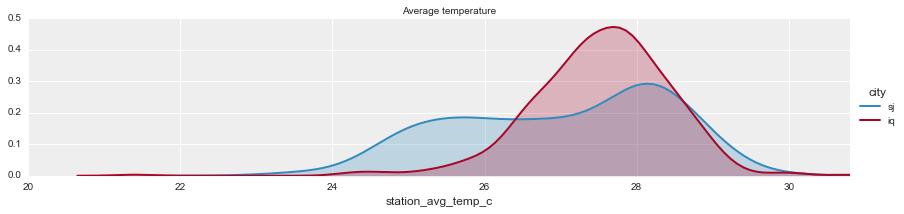

In [15]:
fig = sns.FacetGrid(df, hue='city', aspect=4) 
fig.map(sns.kdeplot,'station_avg_temp_c',shade=True)
max_x = df.station_avg_temp_c.max()
fig.set(xlim=(20,max_x))
fig.add_legend()
fig.fig.suptitle("Average temperature")

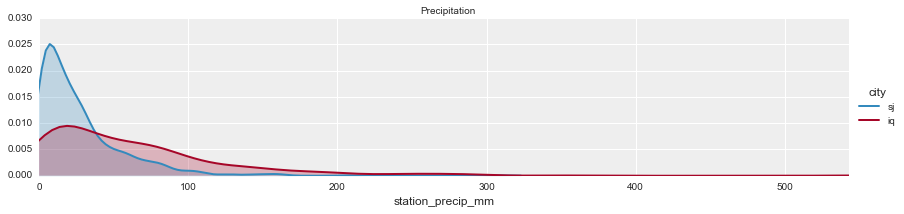

In [16]:
fig = sns.FacetGrid(df, hue='city', aspect=4) 
fig.map(sns.kdeplot,'station_precip_mm',shade=True)
max_x = df.station_precip_mm.max()
min_x = df.station_precip_mm.min()
fig.set(xlim=(0,max_x))
fig.add_legend()
fig.fig.suptitle("Precipitation")

Concerning the climate factors, we can say that Iquitos is generally a littlbe bit hotter than San Juan, and the precipitation is much higher. 

If what our hypothesis is true, the number of dengue cases in Iquitos must be higher than that of San juan.

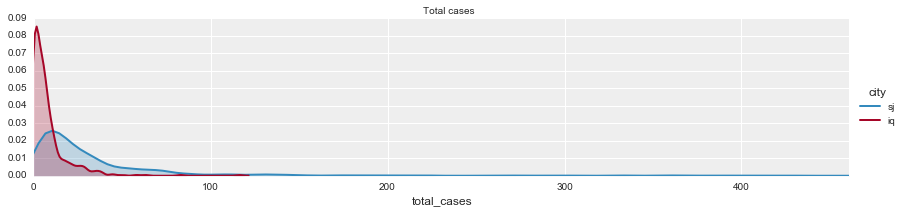

In [17]:
fig = sns.FacetGrid(df, hue='city', aspect=4) 
fig.map(sns.kdeplot,'total_cases',shade=True)
max_x = df.total_cases.max()
min_x = df.total_cases.min()
fig.set(xlim=(min_x,max_x))
fig.add_legend()
fig.fig.suptitle("Total cases")

In [18]:
df.groupby('city').mean().total_cases

city
iq     7.596899
sj    34.122581
Name: total_cases, dtype: float64

Surprisingly, San Juan has a lot more dengue cases than Iquitos 

Now let's check the evolution of dengue disease through time

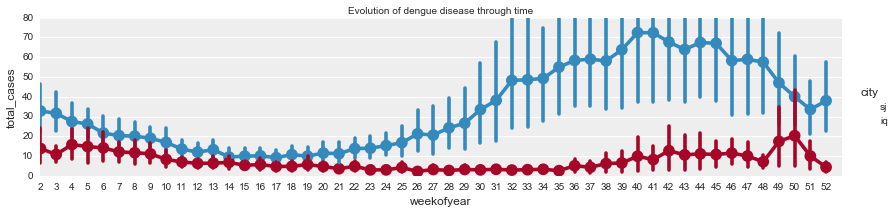

In [19]:
fig = sns.FacetGrid(df, hue='city', aspect=4) 
fig.map(sns.pointplot,'weekofyear','total_cases')
max_x = df.weekofyear.max()
min_x = df.weekofyear.min()
fig.set(xlim=(min_x,max_x))
fig.set(ylim=(0, 80))
fig.add_legend()
fig.fig.suptitle("Evolution of dengue disease through time")

In San Juan, one clear trend is that the dengue virus becomes a lot more active at the other half of the year, starting from July (week 28).

In Iquitos, the disease develop much slower, with its peak at the very end of the year (week 50).

# Baseline model

In [20]:
from sklearn import cross_validation, metrics
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

/Users/admin/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [74]:
def modelfit(alg, dtrain, predictors, target, n_fold=10):
    alg.fit(dtrain[predictors], dtrain[target])
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_prediction = np.round(dtrain_predictions)
    
    cv_mae_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain[target], cv=n_fold, scoring='neg_mean_absolute_error') 
    cv_mae_score = np.abs(cv_mae_score)
  
    
    #Print model report:
    print "\nModel Report: {0}-fold cross-validation".format(n_fold)
    #print "RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions))

    print "Mean absolute error on training set: %.4g" % metrics.mean_absolute_error(dtrain[target].values, dtrain_predictions)
    print "Mean - %.4g | Median - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_mae_score),
                                                                                  np.median(cv_mae_score),
                                                                                  np.std(cv_mae_score),
                                                                                  np.min(cv_mae_score), 
                                                                                  np.max(cv_mae_score))
    

def baseline_test(test_df, predictors, target, plotting=False): 
    
#     base_result = test_df[target][:]
#     base_result[:] = base_result.mean(axis=0)
#     print "NAIVE MODEL: all predictions = mean value" 
#     print "Mean absolute error : %.4g" % np.sqrt(metrics.mean_squared_error(test_df[target].values, base_result))
#     print "----------------------------------------"
    
#     lm = LinearRegression(normalize=False)
#     print "LINEAR REGRESSION" 
#     modelfit(lm, test_df, predictors, target)
#     coef1 = pd.Series(lm.coef_, predictors).sort_values()
#     if plotting: 
#         coef1.plot(kind='barh', title='Model Coefficcients')
#         plt.show()
#     print "----------------------------------------"

    lasso = Lasso(alpha = .01, normalize=False)
    print "LASSO REGRESSION"
    modelfit(lasso, test_df, predictors, target)
    coef1 = pd.Series(lasso.coef_, predictors).sort_values()
    if plotting: 
        coef1.plot(kind='barh', title='Model Coefficcients')
        plt.show()
    print "----------------------------------------"

    print "RANDOM FOREST"
    rf = RandomForestRegressor(n_estimators=200, n_jobs=-1)
    modelfit(rf, test_df, predictors, target)
    rf.fit(test_df[predictors], test_df[target])
    rf.feature_importances_
#     sorted_features =  sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), predictors), 
#                  reverse=True)
    sorted_features = pd.Series(rf.feature_importances_, predictors).sort_values(ascending=False)

#     for x,y in sorted_features: 
#         print y,x 

    if plotting: 
        print "FEATURES SORTED BY THEIR SCORE:\n"
        sorted_features[::-1].plot(kind='barh')
        
    #print "----------------------------------------"



We will encode the "city" feature

In [22]:
df = df.join(pd.get_dummies(df.city))

In [23]:
df.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,iq,sj
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4,0.0,1.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5,0.0,1.0
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4,0.0,1.0
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3,0.0,1.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6,0.0,1.0


We create the list of predictors

In [24]:
np.sum(df.isnull(), axis=0)

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  189
ndvi_nw                                   47
ndvi_se                                   17
ndvi_sw                                   17
precipitation_amt_mm                       3
reanalysis_air_temp_k                      0
reanalysis_avg_temp_k                      0
reanalysis_dew_point_temp_k                0
reanalysis_max_air_temp_k                  0
reanalysis_min_air_temp_k                  0
reanalysis_precip_amt_kg_per_m2            0
reanalysis_relative_humidity_percent       0
reanalysis_sat_precip_amt_mm               3
reanalysis_specific_humidity_g_per_kg      0
reanalysis_tdtr_k                          0
station_avg_temp_c                        33
station_diur_temp_rng_c                   33
station_max_temp_c                        10
station_mi

In [25]:
ignore_feature_list = ['city', 'ndvi_ne', 'week_start_date', 'total_cases']

In [26]:
predictors = [feature for feature in df.columns.tolist() if feature not in ignore_feature_list]
target = 'total_cases'

For the remaining feature with nan values, for now we will just fill the nan values with their mean

In [27]:
df = df.fillna(df.mean())

Ok let's run the baseline models

NAIVE MODEL: all predictions = mean value
Mean absolute error : 43.67
----------------------------------------
LINEAR REGRESSION

Model Report: 10-fold cross-validation
Mean absolute error: 20.36
Mean - 21.87 | Median - 19.6 | Std - 10.48 | Min - 8.53 | Max - 47.36


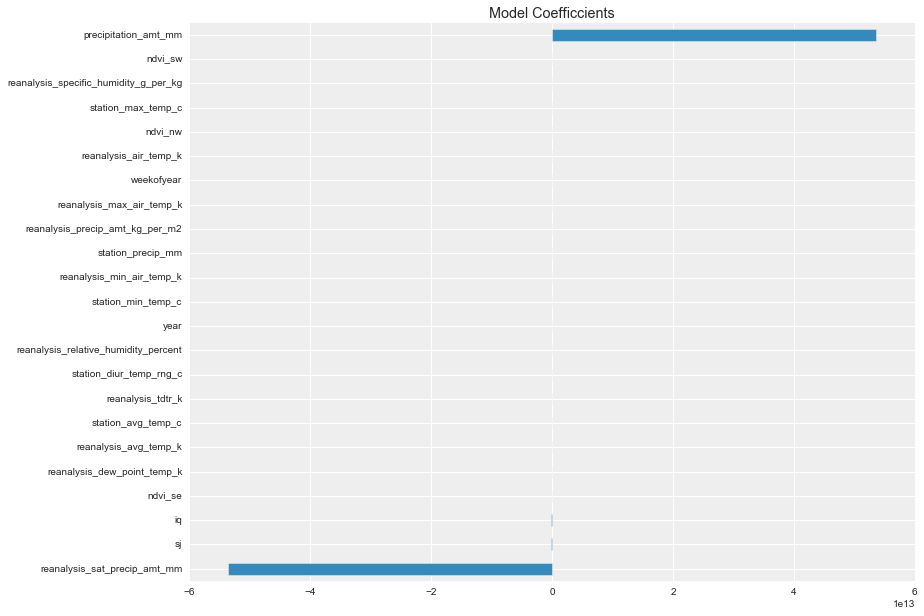

----------------------------------------
LASSO REGRESSION

Model Report: 10-fold cross-validation
Mean absolute error: 20.21
Mean - 21.8 | Median - 19.53 | Std - 10.49 | Min - 8.388 | Max - 47.24


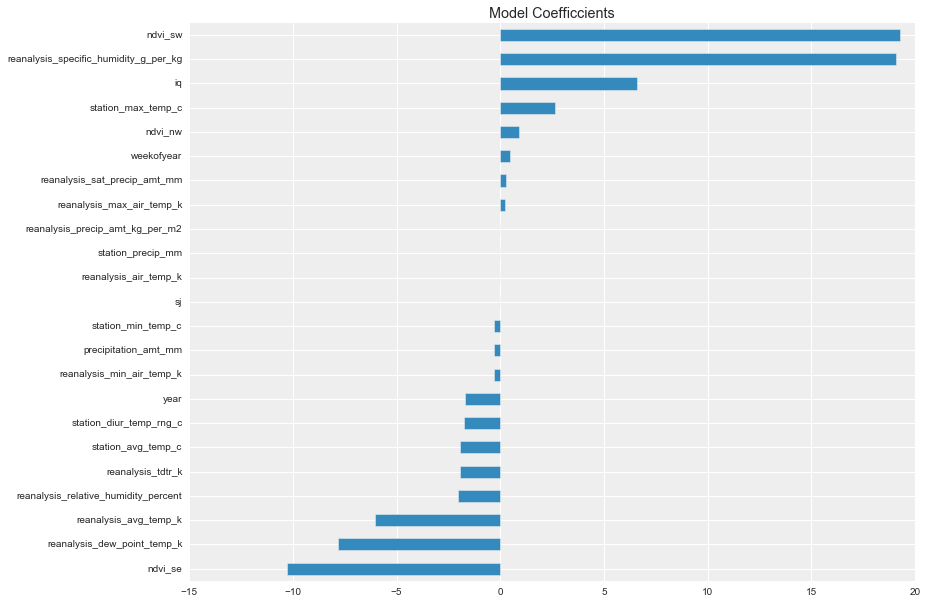

----------------------------------------
RANDOM FOREST

Model Report: 10-fold cross-validation
Mean absolute error: 4.583
Mean - 19.95 | Median - 17.74 | Std - 12.57 | Min - 6.567 | Max - 47.91
FEATURES SORTED BY THEIR SCORE:



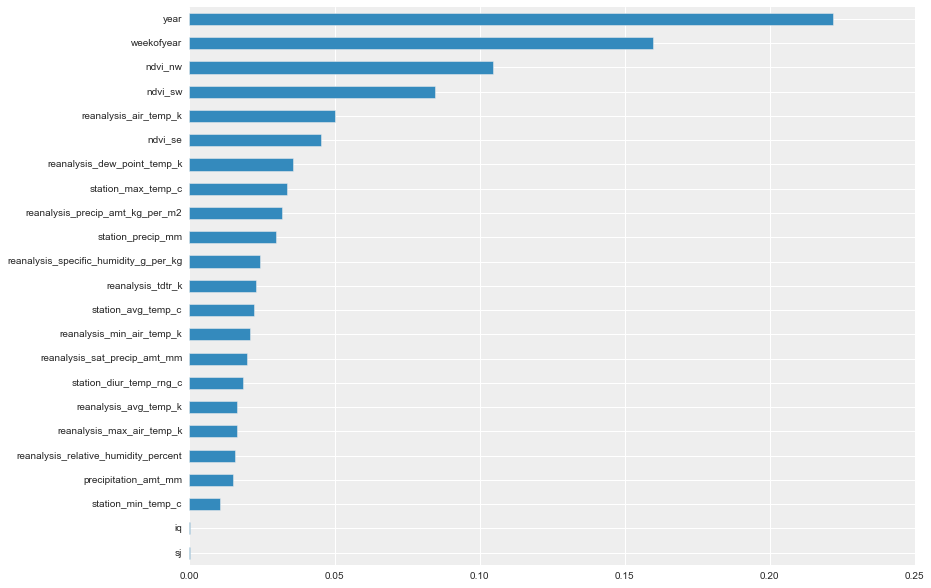

In [36]:
baseline_test(df, predictors, target, plotting=True)

***

## First submission

In [29]:
test = pd.read_csv('data/dengue_features_test.csv')

In [30]:
test = test.fillna(df.mean())

In [31]:
test = test.join(pd.get_dummies(test.city))

In [39]:
def make_prediction(alg, train_df, test_df, predictors, target):

    alg.fit(train_df[predictors], train_df[target])
    predictions = alg.predict(test_df[predictors])
    
    result_df = test_df[['city', 'year', 'weekofyear']].copy()
    result_df['total_cases'] = predictions
    result_df.total_cases = result_df.total_cases.round()
    result_df.total_cases = result_df.total_cases.astype(int)
    
    return result_df

In [52]:
rf = RandomForestRegressor(n_estimators=300, n_jobs=-1)
result = make_prediction(rf, df, test, predictors, target)

In [ ]:
result.to_csv('submission.csv', index=False)

This model gave a leaderboard error of 26,3173.

***

# Separated models

We will build 1 model for each city

In [44]:
df.city.value_counts()

sj    930
iq    516
Name: city, dtype: int64

In [230]:
df_sj = df[df.city == 'sj'].copy()
df_iq = df[df.city == 'iq'].copy()

In [231]:
test_sj = test[test.city == 'sj'].copy()
test_iq = test[test.city == 'iq'].copy()

In [224]:
baseline_test(df_sj, predictors[:-2], target) # omit the 2 dummy predictors about city
baseline_test(df_iq, predictors[:-2], target)

LASSO REGRESSION

Model Report: 10-fold cross-validation
Mean absolute error on training set: 25.94
Mean - 29.04 | Median - 22.51 | Std - 14.66 | Min - 13.45 | Max - 66.36
----------------------------------------
RANDOM FOREST

Model Report: 10-fold cross-validation
Mean absolute error on training set: 5.267
Mean - 29.6 | Median - 27.29 | Std - 16.34 | Min - 8.379 | Max - 64.52
LASSO REGRESSION

Model Report: 10-fold cross-validation
Mean absolute error on training set: 6.272
Mean - 7.293 | Median - 7.172 | Std - 1.851 | Min - 5.118 | Max - 10.15
----------------------------------------
RANDOM FOREST

Model Report: 10-fold cross-validation
Mean absolute error on training set: 1.984
Mean - 7.742 | Median - 7.989 | Std - 1.072 | Min - 5.318 | Max - 9.085


The model works well with Iquitos but not San Juan

In [62]:
rf = RandomForestRegressor(n_estimators=300, n_jobs=-1)

result_sj = make_prediction(rf, df_sj, test_sj, predictors[:-2], target)
result_iq =  make_prediction(rf, df_iq, test_iq, predictors[:-2], target)

result = pd.concat([result_sj, result_iq])

result.to_csv('submission.csv', index=False)

This model gave an error rate of 26.1466, a slight improvement.

***

## Gaussian Process

In [69]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared

In [244]:
rbf_kernel = RBF()
combo_kernel = 2 * RBF(length_scale=2) + 2 * WhiteKernel(noise_level=2)
gp = GaussianProcessRegressor(kernel=combo_kernel,
                              n_restarts_optimizer=10, normalize_y=True)

In [223]:
modelfit(gp, df_sj, predictors[:-2], target) 
modelfit(gp, df_iq, predictors[:-2], target) 


Model Report: 10-fold cross-validation
Mean absolute error on training set: 2.749e-09
Mean - 27.88 | Median - 22.82 | Std - 14.39 | Min - 13.87 | Max - 64.76

Model Report: 10-fold cross-validation
Mean absolute error on training set: 6.646e-10
Mean - 6.735 | Median - 6.616 | Std - 2.025 | Min - 3.77 | Max - 10.24


In [245]:
modelfit(gp, df_sj, predictors[:-2], target) 
modelfit(gp, df_iq, predictors[:-2], target) 

ValueError: array must not contain infs or NaNs

In [232]:
result_sj = make_prediction(gp, df_sj, test_sj, predictors[:-2], target)
result_iq =  make_prediction(gp, df_iq, test_iq, predictors[:-2], target)

result = pd.concat([result_sj, result_iq])

result.to_csv('submission.csv', index=False)

In [233]:
result

,city,year,weekofyear,total_cases
0,sj,2008,18,34
1,sj,2008,19,32
2,sj,2008,20,24
3,sj,2008,21,28
4,sj,2008,22,34
5,sj,2008,23,34
6,sj,2008,24,34
7,sj,2008,25,32
8,sj,2008,26,32
9,sj,2008,27,33


In [246]:
import GPy


In [307]:
kernel = GPy.kern.RBF(input_dim=len(predictors[:-2]), variance=1., lengthscale=1.)

In [313]:
X = df_sj[predictors[:-2]].values
y = np.array([df_sj[target].values]).reshape(-1,1)
X.shape

(930, 21)

In [314]:
m = GPy.models.GPRegression(X,y, kernel)

In [315]:
from IPython.display import display
display(m)

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


In [317]:
m.optimize(messages=True)


In [322]:
r1,r2 = m.predict(df_sj[predictors[:-2]].values)